---
title: 'Getting Started'
toc: true
number-sections: true
mainfont: Arial
format:
  html: default
---

In [1]:
#| echo: false
#| output: false
%load_ext autoreload
%autoreload 2
import sys
sys.path.append(r"..\..\src")  # local path to trimes

This tutorial introduces the basic data structure of *trimes*. It covers basic concepts like (re-)sampling, interpolation and slicing. Other tutorials cover more advanced applications.

# Data Structure
First we create a time series with two curves between 0 and 10 seconds. The time samples are randomly varied (sample time is not constant). This could be for example results of simulations with an adaptive (variable) step solver. Note that there is a separate tutorial where more convenient ways to create time series signals are shown, but we want to illustrate the illustrate the data structure here.

Time samples:
[0.00000000e+00 1.00149175e-03 1.99531417e-03 ... 9.99699761e+00
 9.99799799e+00 1.00000000e+01]


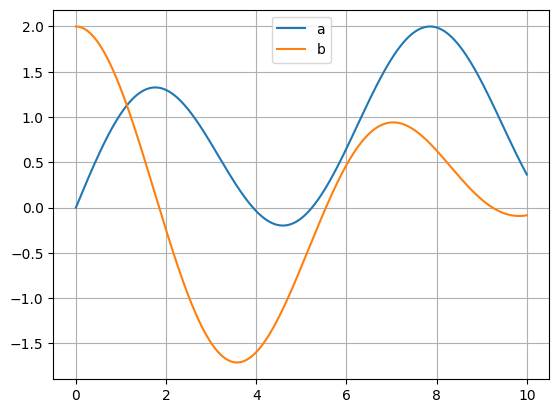

In [2]:
import sys

sys.path.append(r"..\..\src")  # local path to trimes (usually not required)
import trimes
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt


average_sample_time = 1e-3
time = np.arange(0, 10, average_sample_time)
time = time + (np.random.rand(len(time)) - 0.5) * 1e-5
# Make sure that the first time step is zero and the last equals to 10. This is not a generic requirement of trimes, but necessary for this tutorial.
time[0] = 0
time[-1] = 10

val_a = np.sin(time) + np.sin(time * 0.2)
val_b = np.cos(time) + np.cos(time * 0.7)

plt.plot(time, val_a, label="a")
plt.plot(time, val_b, label="b")
plt.legend(loc="upper center")
plt.grid()

print("Time samples:")
print(time)

Let's create a pandas DataFrame. *trimes* requires the index to be the time variable. The index can be set at instantiation of the DataFrame or later using `set_index`.

In [3]:
# Set index at in instantiation
data = {"a": val_a, "b": val_b}
df = pd.DataFrame(data, index=time)
df.index.name = "time"
print("Set index at initialization:")
print(df.head())

# Set index after instantiation
data = {"time": time, "a": val_a, "b": val_b}
df = pd.DataFrame(data)
df.set_index("time", inplace=True)
print("\nSet index after initialization:")
print(df.head())

Set index at initialization:
                 a         b
time                        
0.000000  0.000000  2.000000
0.001001  0.001202  1.999999
0.001995  0.002394  1.999997
0.002999  0.003599  1.999993
0.003997  0.004796  1.999988

Set index after initialization:
                 a         b
time                        
0.000000  0.000000  2.000000
0.001001  0.001202  1.999999
0.001995  0.002394  1.999997
0.002999  0.003599  1.999993
0.003997  0.004796  1.999988


# Getting Data from Transient Time Series

## Get Samples
You can get samples from a DataFrame using the index with the `loc` method. But the input must be exact. Hence, `0.0` is accepted and returns a pandas Series object because there is a sample at exactly that time. However, `0.55` will throw a key error.

In [4]:
df.loc[0.0]  # -> ok, because `0.0` is in df.index
# df.loc[0.55] -> KeyError

a    0.0
b    2.0
Name: 0.0, dtype: float64

The `get_sample` method of *trimes* returns a pandas Series object with the next sample after the queried time:

In [5]:
trimes.get_sample(df, 0.0)  # -> same as df.loc[0.0]
trimes.get_sample(df, 0.55)

a    0.632471
b    1.779319
Name: 0.5500048627774927, dtype: float64

`get_sample` and `get_sample_shifted` accept multiple samples and then return a DataFrame. `get_sample_shifted` shifts the returned samples. For example the input -1 returns the samples before the sample time:

In [6]:
trimes.get_sample_shifted(df, [0.55, 2], -1)

,a,b
time,,
0.548998,0.631412,1.780110
1.998997,1.298948,-0.244576


You can also query samples around a point in time:

In [7]:
trimes.get_samples_around(df, 0.55, -1, 2)

,a,b
time,,
0.548998,0.631412,1.780110
0.550005,0.632471,1.779319
0.551000,0.633516,1.778537


This returns the samples from -1 to 2 (relative to first sample after 0.55).

These methods work with DataFrames as well as with Series:

In [8]:
trimes.get_samples_around(df["a"], 0.55, -1, 2)

time
0.548998    0.631412
0.550005    0.632471
0.551000    0.633516
Name: a, dtype: float64

Whereas `get_sample` returns the values, `get_index` returns their index (index of first sample after point in time):

In [9]:
index = trimes.get_index(df, 0.55)
# Then iloc can be used
df.iloc[index]

a    0.632471
b    1.779319
Name: 0.5500048627774927, dtype: float64

## Interpolation
`interp_df` returns a DataFrame with interpolated (linear) values:

In [10]:
trimes.interp_df(df, [0.5, 3])

,a,b
0.5,0.579259,1.816955
3.0,0.705762,-1.494839


`interp_df` returns a DataFrame even if there is only one sample. You can use `squeeze` to get a Series object:

In [11]:
trimes.interp_df(df, [0.5]).squeeze(axis=0)

a    0.579259
b    1.816955
Name: 0.5, dtype: float64

`interp_series` does the same with a Series as input:

In [47]:
trimes.interp_series(df["b"], [0.5, 0.7])

0.5    1.816955
0.7    1.647175
dtype: float64

## Slicing
The `loc` method of pandas works with slices even if the input time does not fit with the samples (9.5 is not in `time`):

In [13]:
df.loc[9.5:10]

,a,b
time,,
9.501005,0.870082,-0.063874
9.502001,0.869024,-0.064049
9.503002,0.867962,-0.064223
9.504000,0.866902,-0.064397
9.505003,0.865837,-0.064571
...,...,...
9.995002,0.369892,-0.085584
9.995996,0.368974,-0.085502
9.996998,0.368048,-0.085420


The method `get_between` of *trimes* works similar and is more performant. Note that one difference between `loc` and `get_between` is that `get_between` returns samples before the last time sample (in this case before 10).

In [14]:
trimes.get_between(df, 9.5, 10)

,a,b
time,,
9.501005,0.870082,-0.063874
9.502001,0.869024,-0.064049
9.503002,0.867962,-0.064223
9.504000,0.866902,-0.064397
9.505003,0.865837,-0.064571
...,...,...
9.993999,0.370821,-0.085666
9.995002,0.369892,-0.085584
9.995996,0.368974,-0.085502


In [ ]:
%timeit df.loc[9.5:10]
%timeit trimes.get_between(df, 9.5, 10)

*trimes* is more performant because it assumes that the index (time) is monotonously increasing and uses numpy's `searchsorted` function under the hood.

The function 'get_between_and_around' includes the samples before and after the time range (or at the exact points in time) by default. You can use the keyword arguments `include_before` and `include_after` to include or exclude furter samples before and after the time range.

In [16]:
trimes.get_between_and_around(df, 5, 6)

,a,b
time,,
4.999997,-0.117455,-0.652799
5.000998,-0.117062,-0.651592
5.001995,-0.116670,-0.650391
5.003001,-0.116274,-0.649180
5.004004,-0.115877,-0.647970
...,...,...
5.995995,0.648490,0.466341
5.997003,0.649530,0.467241
5.998001,0.650560,0.468130


In [17]:
trimes.get_between_and_around(df, 5, 6, num_samples_start=-2, num_samples_end=2) # inlude two samples at beginning and end

,a,b
time,,
4.999000,-0.117845,-0.653999
4.999997,-0.117455,-0.652799
5.000998,-0.117062,-0.651592
5.001995,-0.116670,-0.650391
5.003001,-0.116274,-0.649180
...,...,...
5.997003,0.649530,0.467241
5.998001,0.650560,0.468130
5.999001,0.651592,0.469020


`get_between_interp` interpolates at `tstart` and `tend`:

In [48]:
trimes.get_between_interp(df, 5.02, 6.02)

,a,b
5.020000,-0.109434,-0.628671
5.020003,-0.109433,-0.628668
5.020998,-0.109024,-0.627466
5.021998,-0.108613,-0.626258
5.023003,-0.108198,-0.625044
...,...,...
6.016005,0.669181,0.484053
6.017005,0.670218,0.484931
6.018004,0.671254,0.485807
6.019003,0.672290,0.486683


## Delta Between Samples
`get_delta` returns the difference between two samples (under the hood `get_sample` is used, so the the next sample after the given time is used).

In [49]:
trimes.get_delta(df, 0, 0.5)

a    0.579262
b   -0.183047
dtype: float64

One can also query the delta between interpolated (linear) values:

In [50]:
delta = trimes.get_delta_interp_df(df, 0, 0.5)
print(delta)
trimes.get_delta_interp_series(df["a"], 0, 0.5)

a    0.579259
b   -0.183045
dtype: float64


np.float64(0.579258954643086)

`get_delta_shift` returns the delta between samples around a point in time, in this case between sample 2 before 0.1 and one sample after 0.1:

In [18]:
trimes.get_delta_shift(df, 0.1, -2, 0)

a    0.002397
b   -0.000298
dtype: float64

# Resampling
The `resample` method... well you guessed it:

             a         b
0.0   0.000000  2.000000
1.0   1.040140  1.305144
2.0   1.298716 -0.246180
3.0   0.705762 -1.494839
4.0  -0.039446 -1.595866
5.0  -0.117453 -0.652795
6.0   0.652624  0.469909
7.0   1.642436  0.940415
8.0   1.988932  0.630066
9.0   1.385966  0.088728
10.0  0.365276 -0.085169


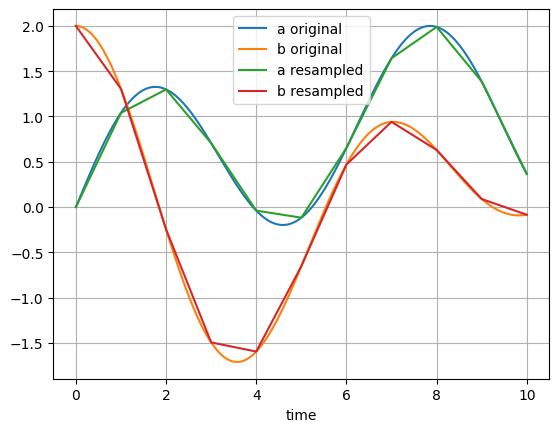

In [20]:
df_resampled = trimes.resample(df, np.arange(0, 10.001, 1))
print(df_resampled)
df["a"].plot(label="a original")
df["b"].plot(label="b original")
df_resampled["a"].plot(label="a resampled")
df_resampled["b"].plot(label="b resampled")
plt.legend(loc="upper center")
plt.grid()